In [1]:
from sklearn.cluster import *
import scipy
import copy
import numpy as np
from matplotlib import pyplot as plt
from Bio import AlignIO
import pickle
import h5py
import itertools
import dendropy

#todo. blur mat up and down tree
#todo. group codons

import os
os.environ['MKL_ENABLE_INSTRUCTIONS'] = 'AVX2'

In [2]:
treefile = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.aln.EPIID.treefile'
alnfile = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.aln'
outsankof = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk5fullcoevmatrev3.pkl'
events = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_*transition_b*.pkl'
prots = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_*AA*.pkl'

protmat = './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.'
import glob

eventmats = glob.glob(events)
protmats = glob.glob(prots)
#eventmats.remove('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_runcoevmat.pkl')


print(len(eventmats))
print(eventmats)
print(protmats)



12
["./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'CG'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'TC'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'CT'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'AT'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'CA'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'AC'_coevmat.pkl", "./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_

In [3]:
allowed_symbols = { b'A', b'C', b'G' , b'T' }
allowed_transitions = [ c1+c2 for c1 in allowed_symbols for c2 in allowed_symbols  if c1!= c2]

print(allowed_transitions)
transition_dict = {  c : i  for i,c in enumerate( allowed_transitions )  }
num2transition = dict(zip(transition_dict.values(), transition_dict.keys() ) )
transition_dict = { c.decode(): transition_dict[c] for c in transition_dict}
num2transition = { val:num2transition[val].decode() for val in num2transition }

print( transition_dict)
print(num2transition)
print( len(transition_dict))

[b'TG', b'TA', b'TC', b'GT', b'GA', b'GC', b'AT', b'AG', b'AC', b'CT', b'CG', b'CA']
{'TG': 0, 'TA': 1, 'TC': 2, 'GT': 3, 'GA': 4, 'GC': 5, 'AT': 6, 'AG': 7, 'AC': 8, 'CT': 9, 'CG': 10, 'CA': 11}
{0: 'TG', 1: 'TA', 2: 'TC', 3: 'GT', 4: 'GA', 5: 'GC', 6: 'AT', 7: 'AG', 8: 'AC', 9: 'CT', 10: 'CG', 11: 'CA'}
12


./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'CG'_coevmat.pkl
CG
(95461, <109535x29903 sparse matrix of type '<class 'numpy.int32'>'
	with 180 stored elements in Compressed Sparse Column format>)
2 3
./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'TC'_coevmat.pkl
TC
(95461, <109535x29903 sparse matrix of type '<class 'numpy.int32'>'
	with 4692 stored elements in Compressed Sparse Column format>)
1 2
./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'CT'_coevmat.pkl
CT
(95461, <109535x29903 sparse matrix of type '<class 'numpy.int32'>'
	with 19671 stored elements in Compressed Sparse Column format>)
2 1
./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'AT'_coe

<AxesSubplot:>

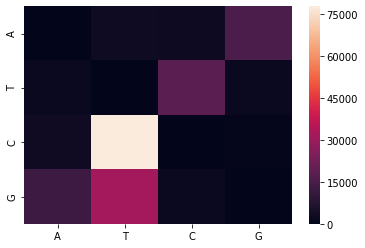

In [12]:
import seaborn as sns
mapping = {'A':0 , 'T':1 , 'C':2 ,'G':3 }
transitionmat = np.zeros( (4,4))
for outsankof in eventmats:
    print(outsankof)
    transition_type = outsankof.replace('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    
    print(transition_type)    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())
        print(coevmat)

    row = mapping[ transition_type[0] ]
    col = mapping[ transition_type[1] ]
    print(row,col)
    
    transitionmat[row,col] = coevmat[1].sum()
sns.heatmap(transitionmat, xticklabels= mapping.keys( ) , yticklabels=mapping.keys())    

In [13]:
#load sankoff coev mat
for outsankof in eventmats:
    
    transition_type = outsankof.replace('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'  , '')
    transition_type = transition_type.replace( '_coevmat.pkl' , '')
    transition_type = transition_type.replace("'" , '')
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    
    coevmat = coevmat.todense()
    
    print(coevmat)
    print(coevmat.shape)
    print(np.amax(coevmat))
    
    sumv = np.sum(coevmat , axis = 0)
    
    print(sumv.ravel().shape)
    print(np.amax(sumv))
    print(np.amin(sumv))
    print(np.mean(sumv))
    print(np.mean(sumv[sumv>0]))
    print(np.std(sumv))

    plt.figure( figsize=(5,5))
    plt.title( transition_type + ' distribution of sum by column' )
    counts,bins = np.histogram(sumv[sumv>0].ravel() , bins = 100)
    centroids = (bins[1:] + bins[:-1]) / 2
    counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
    
    plt.show()
    
    
    
    
    
    
    plt.figure( figsize=(5,5))
    plt.title( transition_type + ' distribution of jack-knife scores' )
    
    counts,bins = np.histogram(coevmat[coevmat>0].ravel() , bins = 100)
    centroids = (bins[1:] + bins[:-1]) / 2
    counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
    
    plt.show()
    
    plt.figure( figsize=(30,20))
    plt.title( transition_type )
    plt.spy(coevmat, markersize= 1)
    plt.show()

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(109535, 29903)


KeyboardInterrupt: 

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(109535, 29903)
10
(1, 29903)
329
0
3.349128849948166
19.050599201065246
12.809591982236626


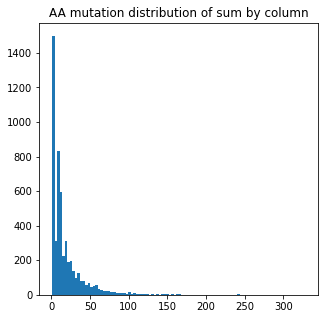

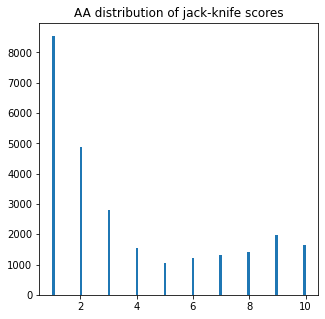

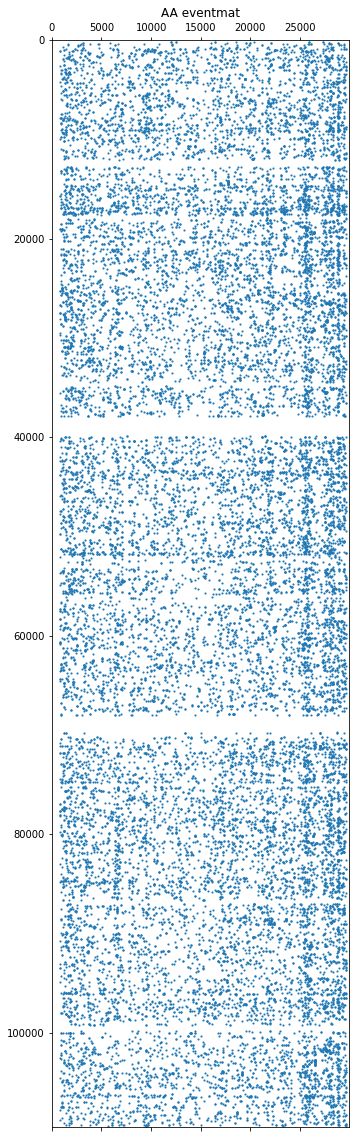

In [6]:
#load sankoff coev mat
for outsankof in protmats:
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    
    coevmat = coevmat.todense()
    
    print(coevmat)
    print(coevmat.shape)
    print(np.amax(coevmat))
    sumv = np.sum(coevmat , axis = 0)
    print(sumv.ravel().shape)
    print(np.amax(sumv))
    print(np.amin(sumv))
    print(np.mean(sumv))
    print(np.mean(sumv[sumv>0]))
    print(np.std(sumv))

    plt.figure( figsize=(5,5))
    plt.title( 'AA mutation distribution of sum by column' )
    counts,bins = np.histogram(sumv[sumv>0].ravel() , bins = 100)
    centroids = (bins[1:] + bins[:-1]) / 2
    counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
    
    plt.show()
    
    plt.figure( figsize=(5,5))
    plt.title( 'AA distribution of jack-knife scores' )
    
    counts,bins = np.histogram(coevmat[coevmat>0].ravel() , bins = 100)
    centroids = (bins[1:] + bins[:-1]) / 2
    counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                             weights=counts, range=(min(bins), max(bins)))
    
    plt.show()
    plt.figure( figsize=(30,20))
    plt.title( 'AA eventmat' )
    plt.spy(coevmat, markersize= 1)
    plt.show()

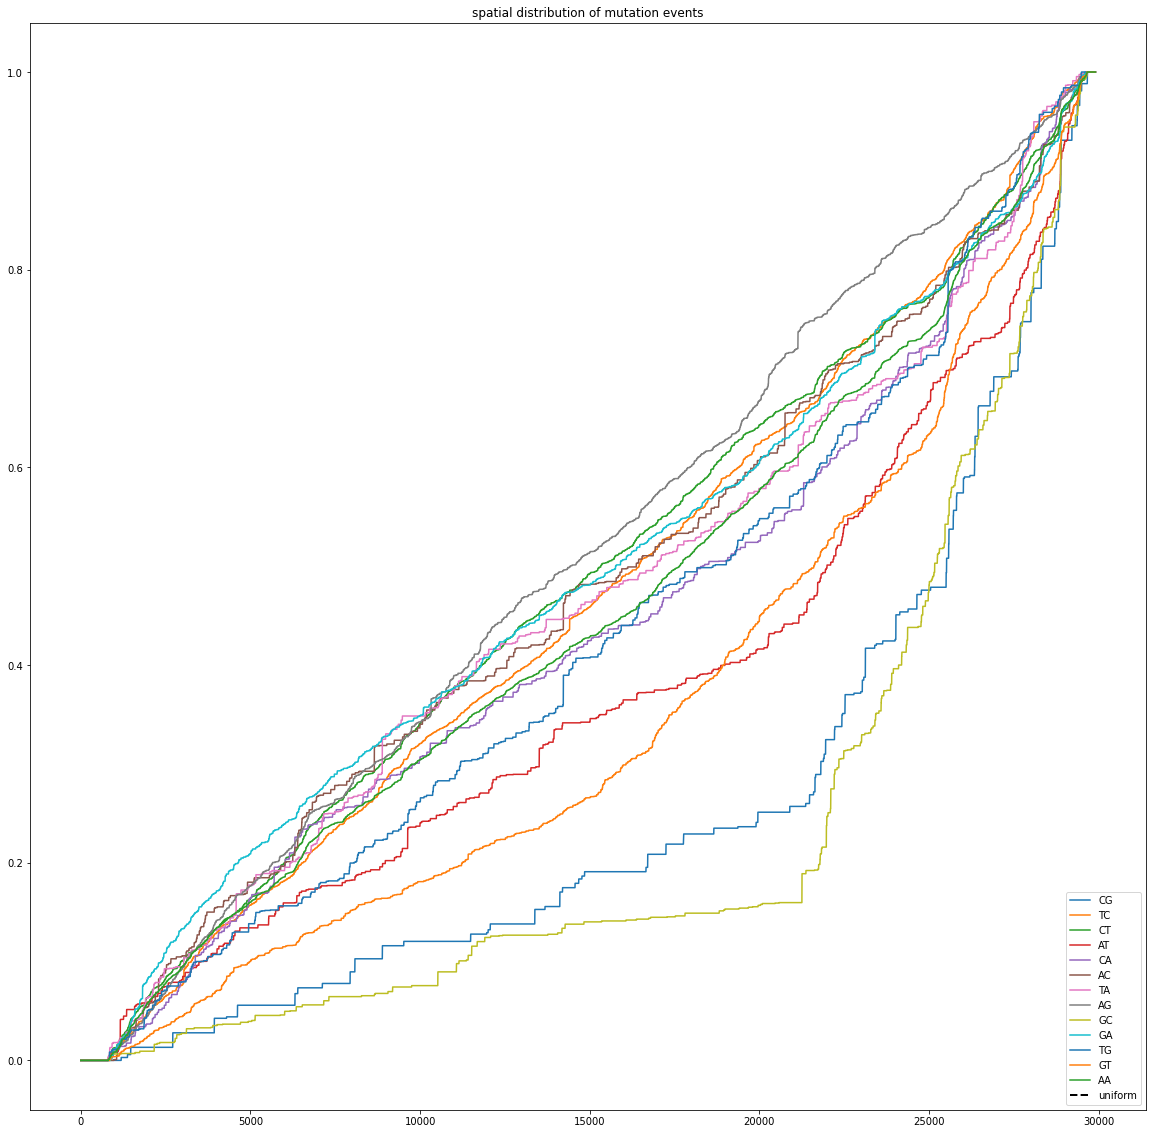

In [7]:
plt.figure( figsize = ( 20,20))
for outsankof in eventmats + protmats:
    if 'AA' not in outsankof:
        transition_type = outsankof.replace('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run_transition_b'  , '')
        transition_type = transition_type.replace( '_coevmat.pkl' , '')
        transition_type = transition_type.replace("'" , '')
    else:
        transition_type = 'AA'
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())[1]
    coevmat = coevmat.todense()
    
    sumv = np.sum(coevmat , axis = 0)
    cdf = np.array( np.cumsum(sumv) / np.sum(sumv))
    plt.plot( cdf[0] , label= transition_type  )
    
cdf_uniform = np.cumsum(np.ones(len(cdf)) ) / np.sum(len(cdf))

plt.plot(cdf_uniform, lw = 2 , ls = 'dashed' , c = 'black' , label= 'uniform')
plt.legend()
plt.title( 'spatial distribution of mutation events' )
plt.show()

In [8]:
#load covid geno
import subprocess
import shlex
import pandas as pd 
#collapse codons
#use tblastn to map to prot
def runblastx( qseq , outannot = 'outannot.txt' , outfmt = None ):
    
    if outfmt is None:
        outfmt = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ]
        outfmt =  ' "10 ' + ''.join([fmt+ ' ' for fmt in outfmt]) + ' " '
        print(outfmt)
    args = 'blastx -query '+ qseq + ' -db covid_prots -outfmt' + outfmt + ' -out ' + outannot  
    p = subprocess.run( shlex.split(args) )
    return p , outannot
out = 'outannot.txt'
p,annot = runblastx( './wuhan.fasta'  )

annotation = pd.read_csv( out , header = None )
annotation.columns = [ 'qseqid' , 'sseqid' , 'qlen' ,  'slen' , 'qstart' , 'qend' ,  'qframe' , 'evalue' ] 
annotation = annotation[ annotation['evalue'] < 10**-3 ]
print(annotation)
print(len(annotation), ' orfs detected')

 "10 qseqid sseqid qlen slen qstart qend qframe evalue  " 
         qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
0   NC_045512.2  YP_009724389.1  29903  7096     266  13468       2   
1   NC_045512.2  YP_009724389.1  29903  7096   13462  21552       1   
3   NC_045512.2  YP_009725299.1  29903  1945    2720   8554       2   
7   NC_045512.2  YP_009742610.1  29903  1945    2720   8554       2   
11  NC_045512.2  YP_009724390.1  29903  1273   21596  25381       2   
12  NC_045512.2  YP_009725307.1  29903   932   13462  16236       1   
13  NC_045512.2  YP_009725298.1  29903   638     806   2719       2   
14  NC_045512.2  YP_009742609.1  29903   638     806   2719       2   
15  NC_045512.2  YP_009725308.1  29903   601   16237  18039       1   
16  NC_045512.2  YP_009725309.1  29903   527   18040  19620       1   
17  NC_045512.2  YP_009725300.1  29903   500    8555  10054       2   
18  NC_045512.2  YP_009742611.1  29903   500    8555  10054       2   
19  NC_045512.2  Y

In [12]:
from Bio import Seq , SeqIO

rows = []
for ID in annotation.sseqid.unique():
    #print(annotation[annotation.sseqid == ID ].iloc[0])
    sub = annotation[annotation.sseqid == ID ]
    rows.append(sub.index[0] ) 
annotation = annotation.loc[rows]
print(len(annotation))
rows = []
for ID in annotation.qstart.unique():
    sub = annotation[annotation.qstart == ID ]
    rows.append(sub.index[0] )
annotation = annotation.loc[rows]
print(len(annotation))
genes =  {}
prots = {}
qseq = next(SeqIO.parse( 'wuhan.fasta' , 'fasta'))
print(qseq)
print(len(qseq))
for i,r in annotation.iterrows():
    genes[i] = qseq[r.qstart-1:r.qend-1]
    #print(genes[i])
    prots[i] = genes[i].translate( )
    annotation = annotation.sort_values( ['qstart'] )
annotation['prots'] = annotation.index.map(prots)
annotation['genes'] = annotation.index.map(genes)
annotation['prots'] =annotation['prots'].map(lambda x : ''.join(x).strip())
annotation['genes'] = annotation['genes'].map(lambda x : ''.join(x).strip())
annotation = annotation[annotation.slen < 2000]
aln_regions = np.array(list(zip(list(annotation.qstart),list(annotation.qend))))
aln_regions= aln_regions[1:,:]
aln_len = np.array(list( annotation.qend - annotation.qstart))
annotation = pd.DataFrame.sort_values(annotation, by='qstart')
print(annotation)


annotation.to_csv(alnfile+'annotation.csv')

36
25
ID: NC_045512.2
Name: NC_045512.2
Description: NC_045512.2 Severe acute respiratory syndrome coronavirus 2 isolate Wuhan-Hu-1, complete genome
Number of features: 0
Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA', SingleLetterAlphabet())
29903
         qseqid          sseqid   qlen  slen  qstart   qend  qframe  \
13  NC_045512.2  YP_009725298.1  29903   638     806   2719       2   
3   NC_045512.2  YP_009725299.1  29903  1945    2720   8554       2   
17  NC_045512.2  YP_009725300.1  29903   500    8555  10054       2   
21  NC_045512.2  YP_009725301.1  29903   306   10055  10972       2   
25  NC_045512.2  YP_009725302.1  29903   290   10973  11842       2   
41  NC_045512.2  YP_009725303.1  29903    83   11843  12091       2   
32  NC_045512.2  YP_009725304.1  29903   198   12092  12685       2   
37  NC_045512.2  YP_009725305.1  29903   113   12686  13024       2   
34  NC_045512.2  YP_009725306.1  29903   139   13025  13441       2   
12  NC_045512.2  YP_0

/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/Bio/Seq.py:2742: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  BiopythonWarning,


In [13]:
#filter for changes relative to wuhan ref.
#!incorrect due to iterative sequential changes.

filtercols = {}
verbose = False
for outsankof in eventmats:
    transition_type = outsankof.replace('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run'  , '')
    transition_type = int(transition_type.replace( '_coevmat_transitionmatrices.pkl' , '') )
    transition_char = num2transition[transition_type].decode()
    print(transition_char)
    delcols = []
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())
    coevmat = coevmat.todense()
    print(coevmat)
    print(coevmat.shape)
    print(np.amax(coevmat))
    sumv = np.sum(coevmat , axis = 1)
    eventcols = list(np.where(sumv > 0)[0])
    for k,col in enumerate(eventcols):
        for i,row in annotation.iterrows():
            col1 = row.qstart
            col2 = row.qend
            if col1 < col and col < col2:
                newseq =  list(row.genes)
                if verbose == True and k < 100:
                    print('orignial: ', ''.join(newseq[ col-col1 -3 : col-col1 + 3]) ) 
                newseq[col-col1] = transition_char[1]
                newseq = ''.join(newseq)
                if verbose == True and k < 100:
                    print( 'mut: ', newseq[ col-col1 -3 : col-col1 + 3])
                if Seq.Seq(newseq).translate() == row.prots:
                    delcols.append(col)
    filtercols[transition_type] = delcols

ValueError: invalid literal for int() with base 10: "_transition_b'CG'_coevmat.pkl"

In [9]:
#might be interesting to see the spatial distribution of synonymous mutations too

for key in filtercols:
    print(num2transition[key])
    print(len(filtercols[key]))

b'AG'
781
b'GC'
43
b'CT'
243
b'CG'
51
b'CA'
65
b'TA'
31
b'AC'
61
b'GT'
49
b'GA'
264
b'TG'
340
b'TC'
179
b'AT'
15


In [10]:
collapse_mat = None
collapse_mat_filtered = None
print(eventmats)

['./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run6_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run0_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run5_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run3_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run4_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run11_coevmat_transitionmatrices.pkl', './lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.al

In [11]:
for outsankof in eventmats:
    transition_type = outsankof.replace('./lucy_mk3/gisaid_hcov-2020_08_25.QC.NSoutlier.filter.deMaiomask.EPIID.alnCOEV_cleantree_mk6bootstrap_runbootstrap_run'  , '')
    transition_type = int(transition_type.replace( '_coevmat_transitionmatrices.pkl' , '') )
    print(num2transition[transition_type])
    
    with open( outsankof , 'rb') as matin:
        coevmat = pickle.loads(matin.read())
        coevmat = coevmat.todense()
    
    if collapse_mat is not None:
        collapse_mat += coevmat 
    else:
        collapse_mat = coevmat
    coevmat[:,filtercols[transition_type]] =0
    if collapse_mat_filtered is not None:
        collapse_mat_filtered += coevmat
    else:
        collapse_mat_filtered = coevmat
    print('done')

b'AG'
done
b'GC'
done
b'CT'
done
b'CG'
done
b'CA'
done
b'TA'
done
b'AC'
done
b'GT'
done
b'GA'
done
b'TG'
done
b'TC'
done
b'AT'
done


In [12]:
print(collapse_mat)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


(1, 29903)
86
0
0.4800521686787279
22.931309904153355
3.656403844209938


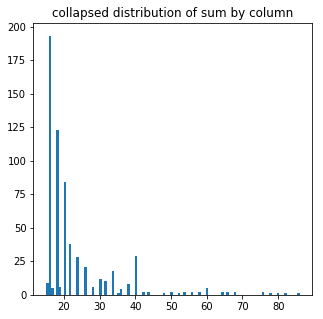

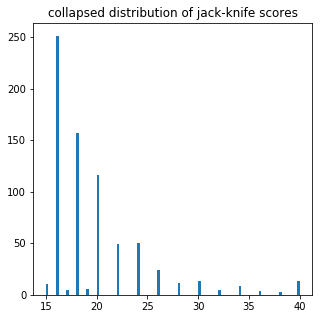

In [87]:
sumv = np.sum(collapse_mat , axis = 0)

print(sumv.ravel().shape)
print(np.amax(sumv))
print(np.amin(sumv))
print(np.mean(sumv))
print(np.mean(sumv[sumv>0]))
print(np.std(sumv))

plt.figure( figsize=(5,5))

plt.title('collapsed distribution of sum by column' )
counts,bins = np.histogram(sumv[sumv>0].ravel() , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                         weights=counts, range=(min(bins), max(bins)))

plt.show()


plt.figure( figsize=(5,5))
plt.title('collapsed distribution of jack-knife scores' )

counts,bins = np.histogram(collapse_mat[collapse_mat>0][0] , bins = 100)
centroids = (bins[1:] + bins[:-1]) / 2
counts_, bins_, _ = plt.hist(centroids, bins=len(counts),
                         weights=counts, range=(min(bins), max(bins)))

plt.show()
    

In [19]:
def sumcodons(submat_coev, annotation):#sum up to codonmat
    print('summing up events on codons')
    codonmat =np.zeros( (submat_coev.shape[0] , int(submat_coev.shape[1]/3) +1  ))
    count = 0
    print(codonmat.shape)
    print(submat_coev.shape)
    '''try:
        submat_coev = submat_coev.todense()
    except AttributeError:
        print( 'already dense')
    '''
    
    codon_dict = {}
    for i,r in annotation.iterrows():
        for j,codon in enumerate(range(r.qstart-1, r.qend-1 , 3 )):
            codon_dict[codon] = count
            cols = np.sum( submat_coev[:, codon:codon+2] , axis = 1 )
            codonmat[:,count] = cols.ravel()
            count+=1
            if count%500 == 0:
                print(count/codonmat.shape[1])
    codon_dict_rev = dict(zip ( codon_dict.values() , codon_dict.keys( ) ) )
    
    return scipy.sparse.csc_matrix( codonmat ) , codon_dict , codon_dict_rev


In [20]:
from sklearn.cluster import MiniBatchKMeans , DBSCAN
import sklearn

def return_clustering(codonmat):
    apb = MiniBatchKMeans(n_clusters=100, init='k-means++', max_iter=100, batch_size=200, verbose=1, compute_labels=True , random_state= 0   )
    #apb = DBSCAN( eps = .5 , metric='cosine', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=-1)
    cluster_labels_codon = apb.fit_predict(codonmat.T )
    return cluster_labels_codon


In [21]:
tree = dendropy.Tree.get(
    path=treefile,
    schema='newick')
for l in tree.leaf_nodes()[0:10]:
    print(str(l.taxon))
print(len(tree.leaf_nodes()))
print('leaves')

for i,n in enumerate(tree.nodes()):
    n.matrow = i
    n.symbols = None
    n.scores = None
    n.event = None
    n.char = None
matsize = len(tree.nodes())
print(matsize)
print('nodes')

'EPI ISL 475635'
'EPI ISL 425848'
'EPI ISL 433289'
'EPI ISL 439066'
'EPI ISL 433434'
'EPI ISL 417064'
'EPI ISL 434563'
'EPI ISL 434564'
'EPI ISL 425865'
'EPI ISL 464788'
54768
leaves
109535
nodes


In [47]:
#blur w connectivity mat
blurfactor =  .5
bluriter = 4
connectmat = scipy.sparse.csc_matrix((len(tree.nodes()), len(tree.nodes() ) ) )
index = np.array([ [n.matrow, c.matrow ] for n in tree.nodes() for c in n.child_nodes()])
connectmat[index[:,0],index[:,1]] = 1
connectmat[index[:,1],index[:,0]] = 1



/home/cactuskid13/miniconda3/envs/pyprofiler3/lib/python3.7/site-packages/scipy/sparse/_index.py:127: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


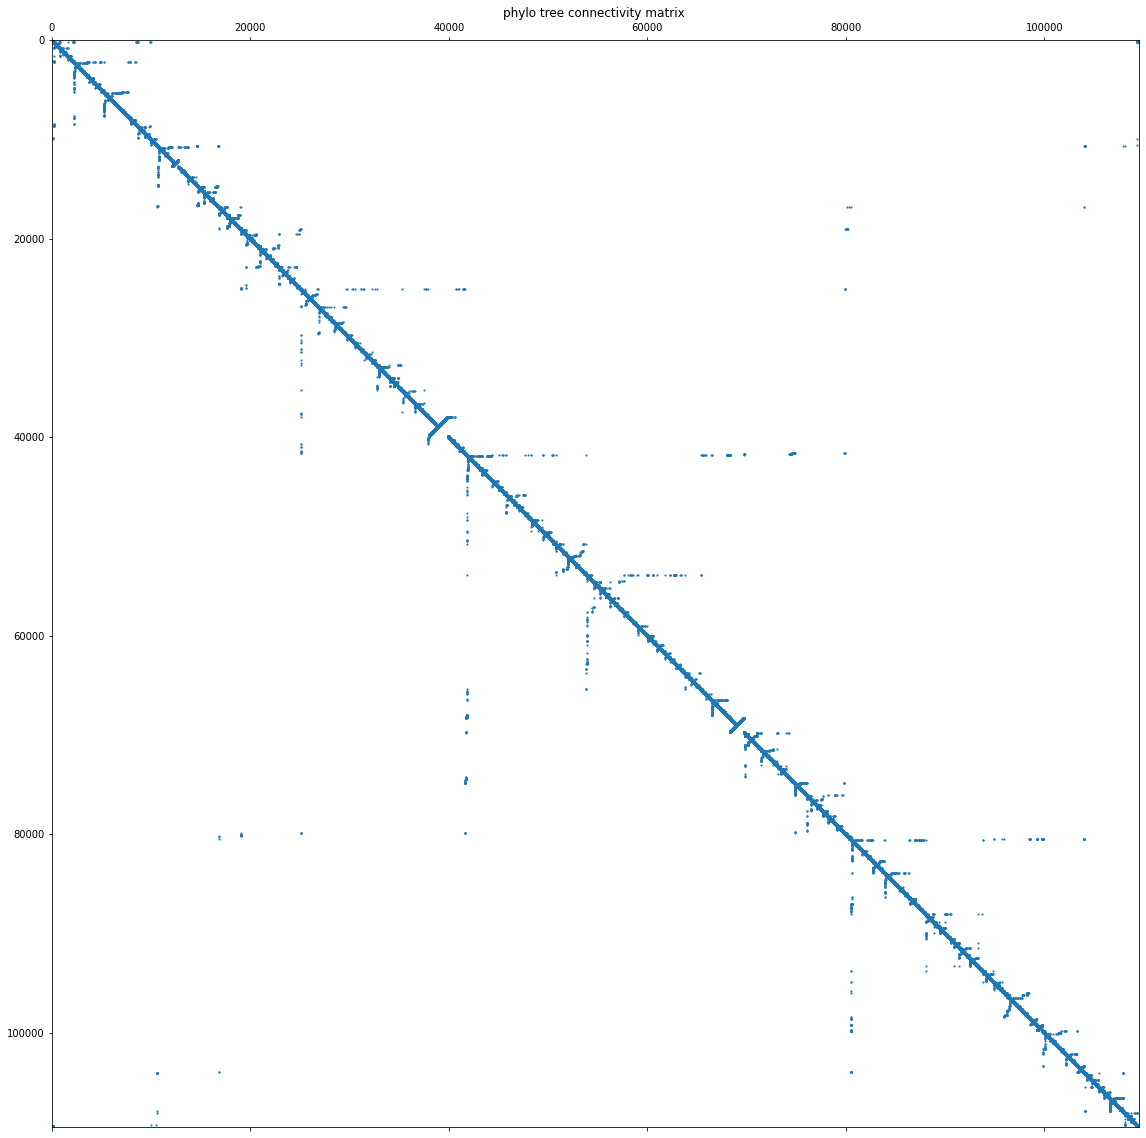

In [23]:

plt.figure( figsize=(30,20))
plt.title( 'phylo tree connectivity matrix ' )
plt.spy(connectmat, markersize= 1)
plt.show()

In [78]:
from sklearn.manifold import Isomap

#one shot clustering

codonmat_clean , codon_dict, codon_dict_rev = sumcodons(mat , annotation )


codonmat = copy.deepcopy(codonmat)
#reduce dim w isomap
bluriter = 8
blurfactor = .25
for k in range( bluriter):
    print('blurring')
    codonmat += np.dot(blurfactor*connectmat, codonmat)
    print(k)

summing up events on codons
(109535, 9968)
(109535, 29903)
0.05016051364365971
0.10032102728731943
0.15048154093097912
0.20064205457463885
0.25080256821829855
0.30096308186195825
0.351123595505618
0.4012841091492777
0.4514446227929374
0.5016051364365971
0.5517656500802568
0.6019261637239165
0.6520866773675762
0.702247191011236
0.7524077046548957
0.8025682182985554
0.8527287319422151
0.9028892455858748
0.9530497592295345
blurring
0
blurring
1
blurring
2
blurring
3
blurring
4
blurring
5
blurring
6
blurring
7


In [ ]:
isomap = Isomap( n_neighbors=5, n_components=int(codonmat.shape[0]/100), eigen_solver='auto', tol=0, 
                max_iter=None, path_method='auto', neighbors_algorithm='auto', n_jobs=-1 )

codonmat_isomap = isomap.fit_transform( X=codonmat.T ).T



#dist between cluster columns is their link strength

In [ ]:
print(codonmat_isomap.shape)
cluster_labels =  return_clustering(codonmat_isomap)
l,c = np.unique(cluster_labels, return_counts= True)
print(len(l))
print(c)
totalgraph= {}

for n,label in enumerate(list(l)):
    #find all combinations
    graph = {}
    if c[n]>1 and c[n]< 1000 :
        edges = [  (e1,e2) for e1,e2 in itertools.combinations( list(np.where(  cluster_labels == label )[0]) , 2) ]
        graph = { (e1,e2):( np.linalg.norm( codonmat_isomap[:,e1] - codonmat_isomap[:,e2] )) for e1,e2 in edges }
        totalgraph.update(graph)

        
import networkx as nx

G = nx.Graph()
G.add_weighted_edges_from([ (k[0],k[1],totalgraph[k]) for k in totalgraph ])
#create subgraphs
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]



In [ ]:
#random pairs

#sumv = np.sum( codonmat_clean , axis = 0)
sumv = codonmat.sum( axis =0 )
plt.hist(sumv)
plt.show()

print(codonmat_isomap.shape)

indices = np.where(np.abs(sumv) > 0 )[0]

print(len(indices))
print(indices)


[0 0 0 ... 0 0 0]
[0. 0. 0. ... 0. 0. 0.]


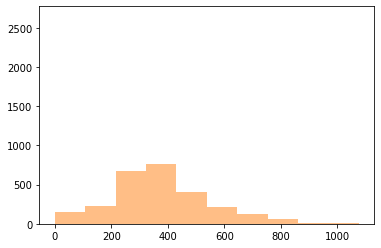

In [75]:
random_pairs = np.vstack( [ np.random.randint(indices.shape[0], size=len(edge_dist)) , np.random.randint(indices.shape[0], size=len(edge_dist)) ] )
bgvalues = []

edge_dist = [ e[2]['weight'] for e in G.edges(data = True) ]

print(indices)
for i in range(len(edge_dist)):
    c1,c2 = random_pairs[:,i]
    c1 = indices[c1]
    c2 = indices[c2]
    bgvalues.append(np.linalg.norm(codonmat_isomap[:,c1] - codonmat_isomap[:,c2]))
    
bgvalues = np.array(bgvalues)
print(bgvalues)
plt.hist(bgvalues , alpha = .5)
plt.hist(edge_dist ,alpha = .5)
plt.show()

[9081, 5052, 8015]


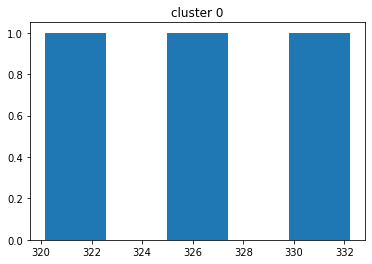

AttributeError: module 'matplotlib.cbook' has no attribute 'iterable'

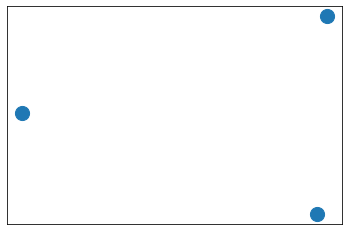

In [43]:
final_labels = np.zeros( codonmat_isomap.shape[1] )
component_lengths = []

for i,s in enumerate(S):
    component_lengths.append(len(s))
    if len(s) > 2:
        print(s.nodes())
        plt.figure()
        plt.title( 'cluster ' + str(i) )
        plt.hist( [ e[2]['weight'] for e in s.edges(data = True) ] , bins = 5)
        plt.show()
        pos = nx.spring_layout(s)  # positions for all nodes
        # nodes
        nx.draw_networkx_nodes(s, pos, node_size=200)
        # edges
        max_weight = np.amax([ e[2]['weight'] for e in s.edges(data = True) ] ) 
        edge_widths = 1 * np.log( np.array([ e[2]['weight'] for e in s.edges(data = True) ]) / max_weight )
        nx.draw_networkx_edges(s, pos, edgelist=s.edges(), width= edge_widths )
        # labels
        nx.draw_networkx_labels(s, pos, font_size=10, font_family="sans-serif")
        plt.axis("off")
        plt.show()
        final_labels[s.nodes()] = i
plt.figure()
plt.title( 'nodes in connected components ' )
plt.hist( component_lengths )
plt.show()

In [ ]:
#cluster w multiple replicates

#cluster at diff levels of jackknife thresh
#filter cols from each mat that are synonimous mutations
clustersets = {}

with open( outsankof , 'rb') as matin:
    coevmat = pickle.loads(matin.read())[1]

    
    

coevmat = coevmat.todense()
for i,mat in enumerate([coevmat]):
    for thresh in [ 0, 5 , 10 , 15]:
        if thresh not in clustersets:
            clustersets[thresh] = {}   
        for j,blur in enumerate([ False , True ]):
            mat[mat<thresh] = 0
            print(np.amin(mat[mat>0]))
            
            codonmat , codon_dict, codon_dict_rev = sumcodons(mat , annotation )
            if i not in clustersets[thresh]:
                clustersets[thresh][i] = {}
            if blur == True:
                for k in range( bluriter):
                    print('blurring')
                    codonmat += np.dot(blurfactor*connectmat, codonmat)
                    print(k)
            codonmat.sum_duplicates()
            cluster_labels =  return_clustering(codonmat)
            clustersets[thresh][i][j] = cluster_labels            
            l,c = np.unique(cluster_labels, return_counts= True)
            print(len(l))
            print(c)
            with open( alnfile+'cluster_iter.pkl' , 'wb')as clusterout:
                clusterout.write( pickle.dumps( clustersets ))


In [34]:
#save codon clustering
with open( alnfile+'cluster_iter.pkl' , 'wb')as clusterout:
    clusterout.write( pickle.dumps( clustersets ))
    

In [ ]:
with open( alnfile+'cluster_iter.pkl' , 'rb')as clusterout:
    clustersets = pickle.loads( clusterout.read() )
    

In [ ]:
import itertools 
totalgraph = {}

for i in clustersets:
    for j in clustersets[i]:
        for k in clustersets[i][j]:
            l,c = np.unique( clustersets[i][j][k], return_counts= True)
            #if cluster is a reasonable size
            for n,label in enumerate(list(l)):
                #find all combinations
                if c[n]>1 and c[n]< 1000 :
                    edges = [  (e1,e2) for e1,e2 in itertools.combinations( list(np.where(  clustersets[i][j][k] == label )[0]) , 2) ]
                    graph = { (e1,e2):(  1 if (e1,e2) not in totalgraph
                             else totalgraph[(e1,e2)]+1) for e1,e2 in edges }
                    totalgraph.update(graph)

In [ ]:
#define thresh for conenctivity




In [ ]:
plt.hist(list( totalgraph.values()), bins = 10 )
plt.show()
connections = np.array(list( totalgraph.values()))

plt.hist(connections[connections>2], bins = 10 )
plt.show()

In [70]:
totalgraph = { (e1,e2):totalgraph[(e1,e2)] for e1,e2 in totalgraph if totalgraph[(e1,e2)] > 5  }


In [71]:
import networkx as nx

G = nx.Graph()
G.add_weighted_edges_from([ (k[0],k[1],totalgraph[k]) for k in totalgraph ])
#create subgraphs
S = [G.subgraph(c).copy() for c in nx.connected_components(G)]


[1154, 7078, 392, 2250, 778, 8365, 912, 9106, 9428, 8503, 3162, 219, 9534, 7519]


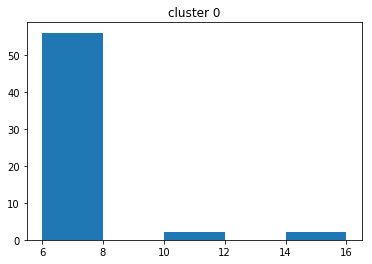

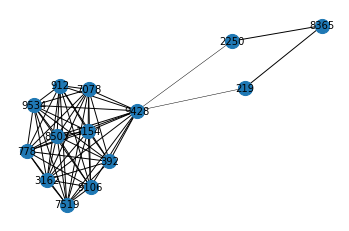

[2577, 9204, 6815]


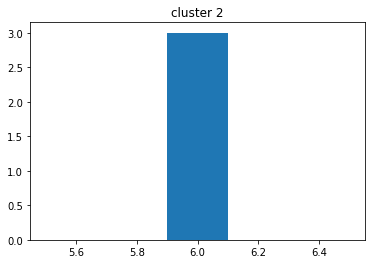

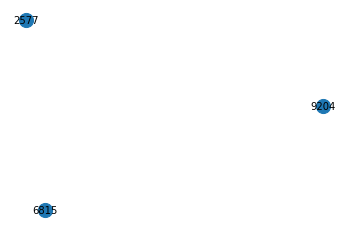

[8193, 9508, 172, 5997, 8018, 9086]


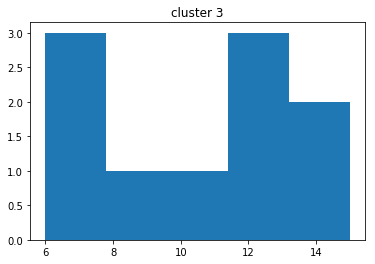

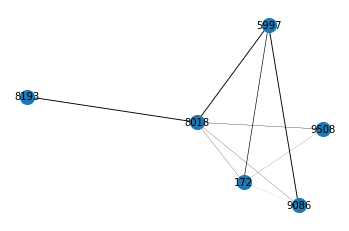

[1, 2981, 9542, 3434, 8074, 8203, 3410, 4405, 6038]


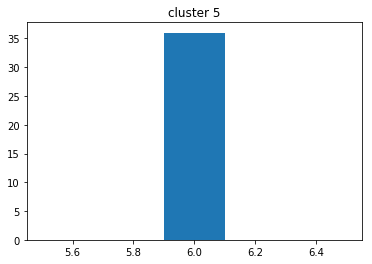

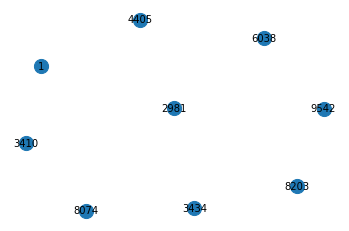

[26, 421, 437, 703, 732, 827, 928, 1740, 2058, 2580, 2691, 2890, 3143, 3356, 3474, 3547, 3968, 4419, 4461, 4851, 4903, 5677, 5795, 6011, 6094, 6097, 6687, 6729, 7147, 7373, 7576, 7577, 7734, 8011, 8015, 8116, 8345, 8366, 8526, 8535, 8572, 8797, 8895, 9100, 9232, 9282, 9285, 9303, 58, 1048, 1247, 2953, 3392, 3566, 3708, 3889, 4389, 5137, 5432, 5780, 6049, 8498, 9216, 113, 698, 835, 883, 3744, 4457, 4785, 5042, 5837, 6026, 6479, 6718, 6973, 8239, 8390, 8972, 9099, 114, 666, 5300, 5551, 5568, 6312, 6500, 6770, 7380, 7662, 7726, 7833, 8211, 8649, 8811, 9121, 9502, 141, 6412, 8104, 8943, 198, 404, 1381, 1976, 2272, 2273, 6959, 7511, 8804, 211, 695, 1260, 1835, 5621, 7048, 8421, 9051, 276, 474, 1637, 3693, 4811, 8259, 8507, 9517, 6384, 6918, 8965, 9172, 1114, 1370, 2424, 2455, 3106, 3541, 4365, 5238, 7578, 9034, 9155, 9339, 1143, 1834, 3479, 4980, 6875, 7308, 8898, 1605, 8197, 3917, 4922, 5811, 5857, 7555, 8684, 8795, 5970, 8043, 8755, 9029, 3239, 4792, 6298, 9073, 7742, 8261, 446, 3665, 822

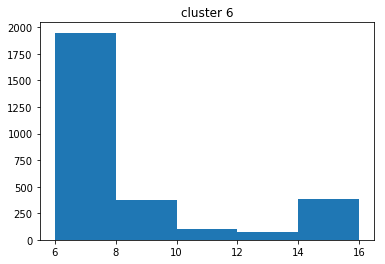

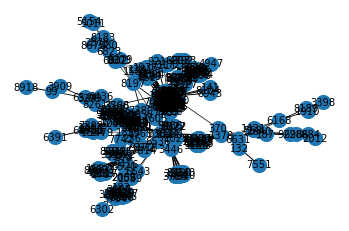

[96, 5185, 2432, 9380, 8395, 9036, 9292, 9291, 84, 7924, 8666, 5914, 6109]


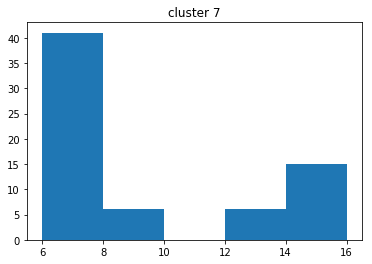

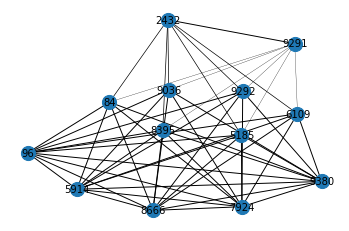

[547, 6581, 7110]


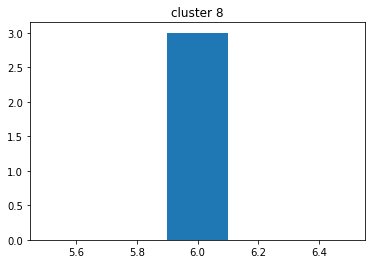

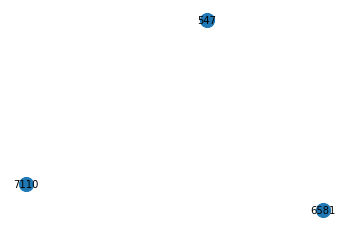

[8208, 8372, 567]


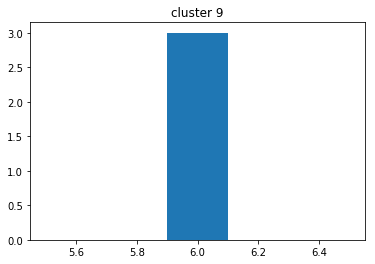

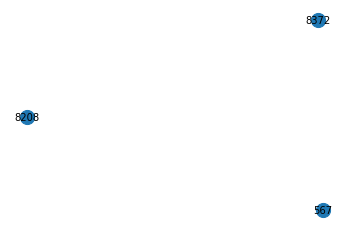

[2400, 1433, 5611]


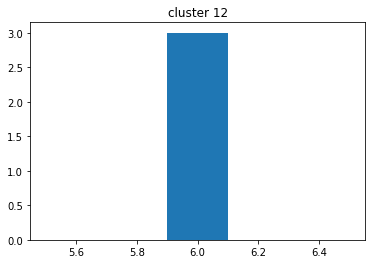

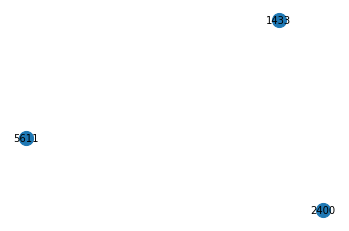

[8355, 8036, 7236, 7237, 8775, 7178, 7536, 8978, 2453, 1880, 3323, 8923, 9432]


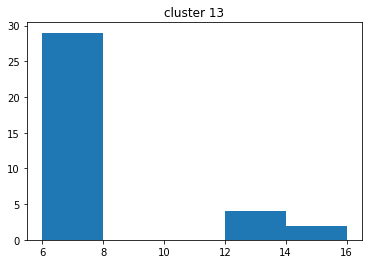

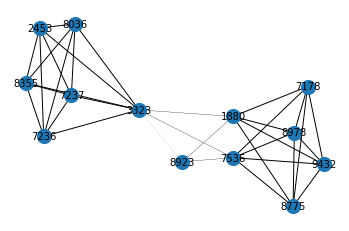

[8807, 5904, 2612, 5428, 4767]


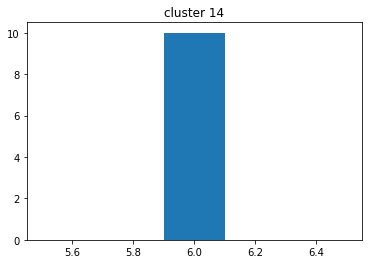

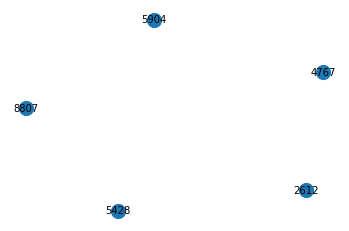

[2898, 6483, 9527]


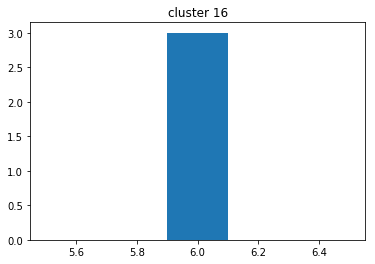

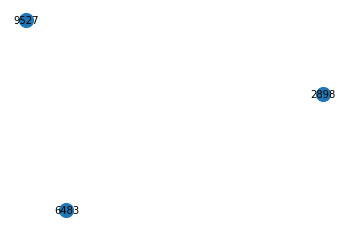

[4584, 3442, 8060]


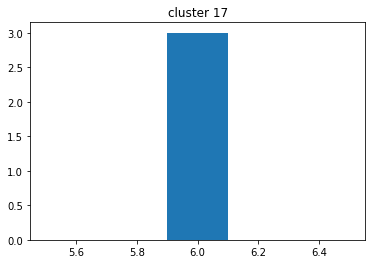

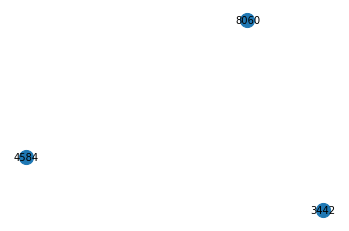

[6297, 8393, 7173]


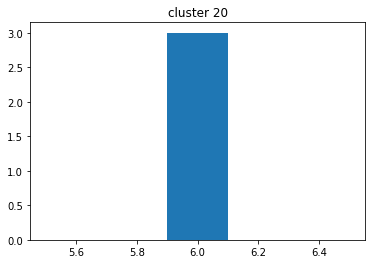

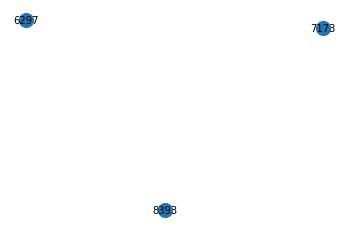

[9281, 8997, 8325, 265, 8523, 7374, 7598, 6524, 1659, 9244]


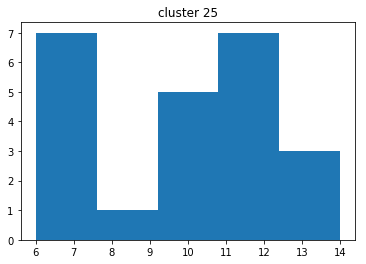

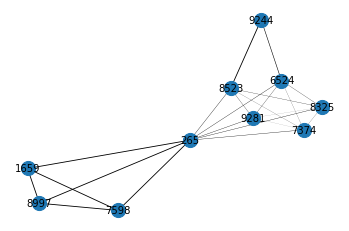

[3057, 5594, 4289]


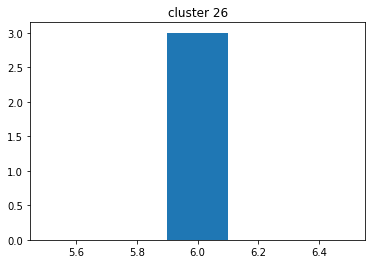

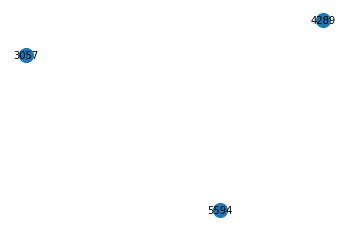

[6913, 9315, 263, 2959, 9113]


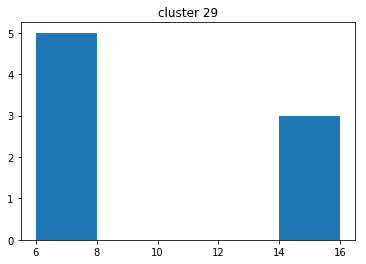

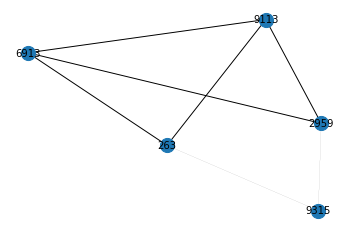

[1519, 6053, 7382, 5287]


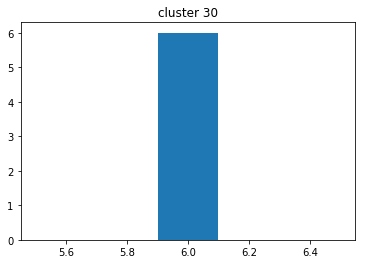

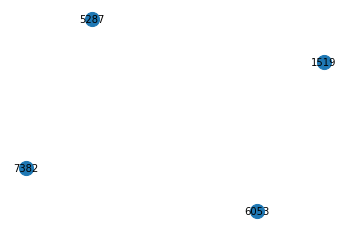

[8139, 3500, 15, 2609, 8242, 2812]


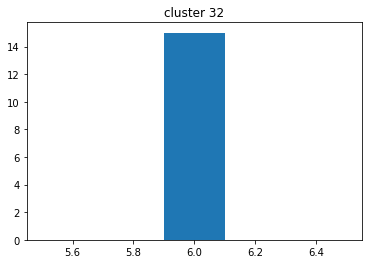

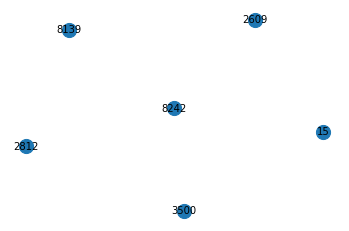

[4840, 5097, 3682, 8205]


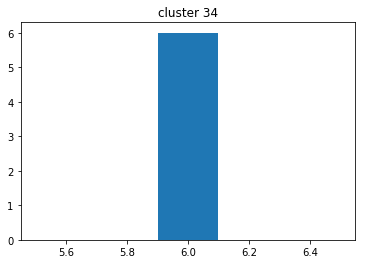

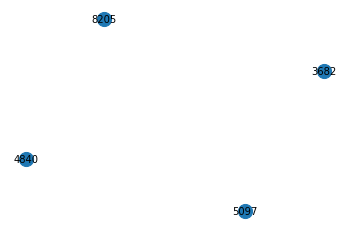

[331, 9239, 7806, 1135]


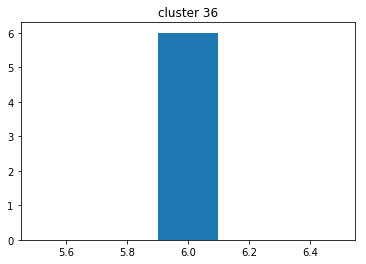

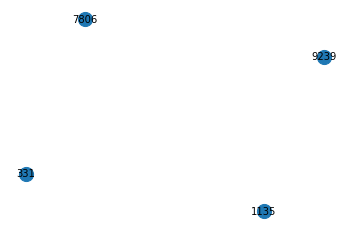

[1860, 581, 3336, 4591, 818, 8307, 6999, 9240, 7775]


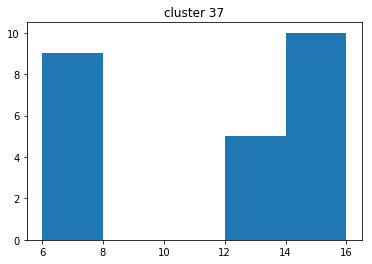

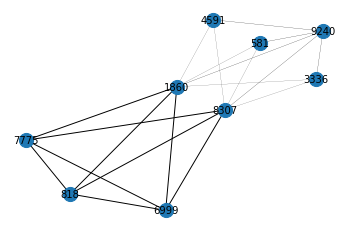

[1849, 5877, 3550]


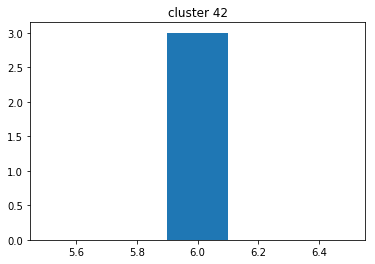

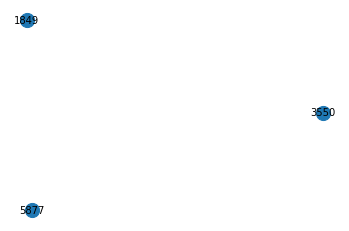

[5632, 7667, 8924, 3495]


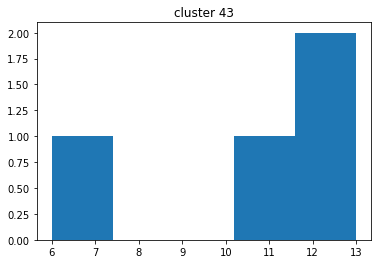

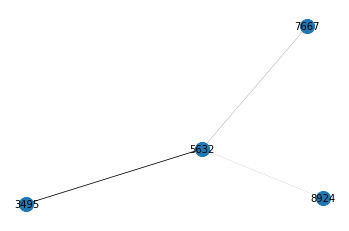

[4288, 3937, 5856, 8883, 8600]


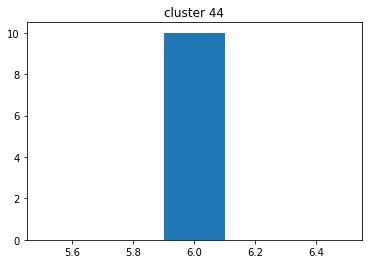

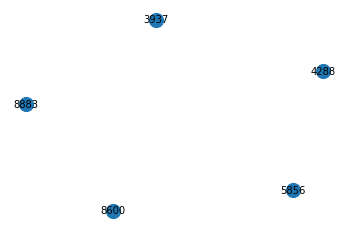

[496, 5555, 711]


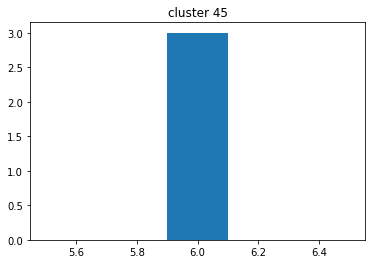

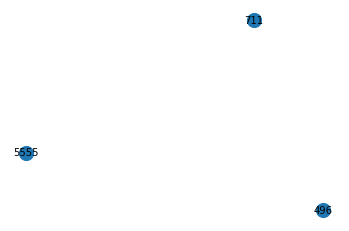

[338, 2251, 7035]


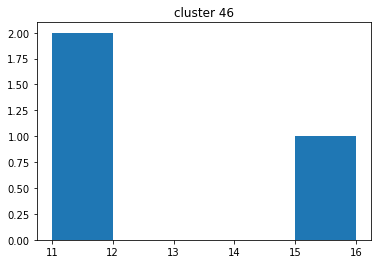

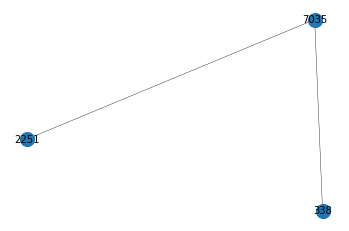

[5362, 2926, 4978, 1542]


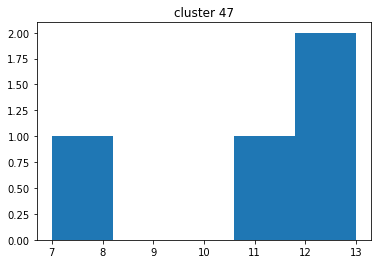

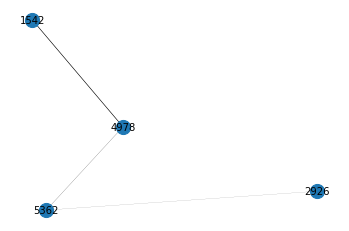

[9107, 8734, 9451]


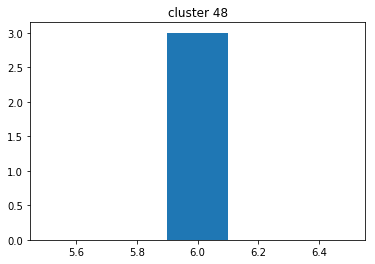

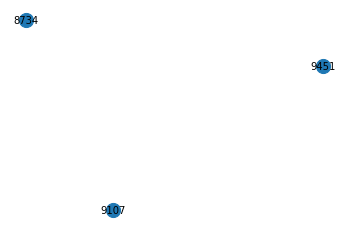

[5223, 2, 180, 8975]


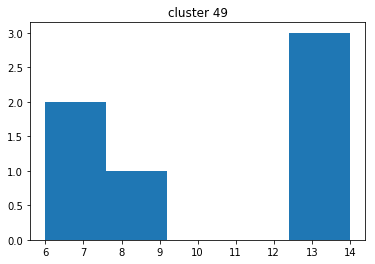

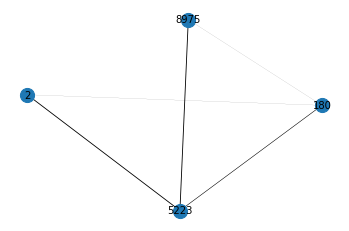

[1898, 8514, 6805]


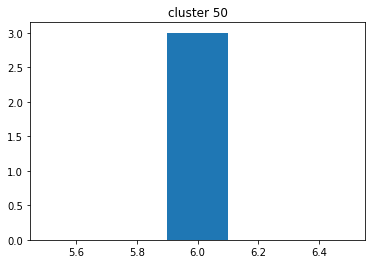

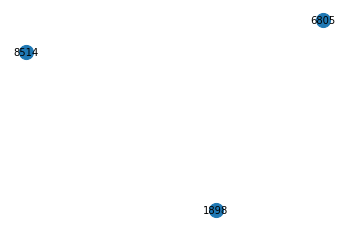

[5818, 8188, 8301, 1130]


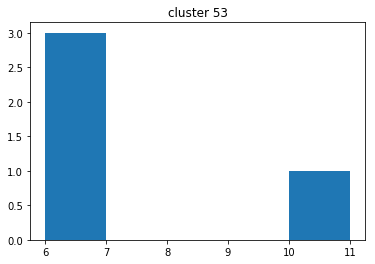

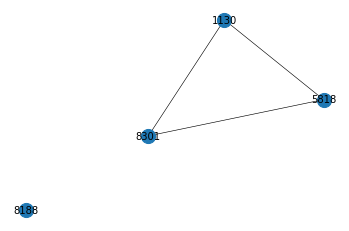

[2584, 2585, 3128]


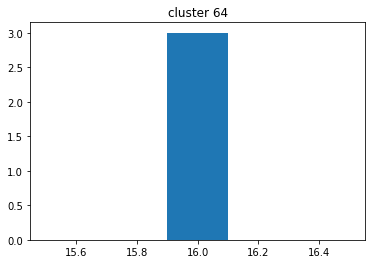

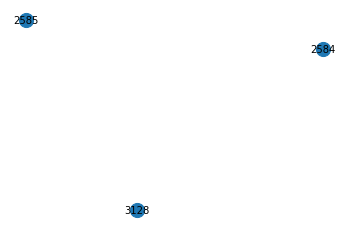

[9489, 7572, 7150]


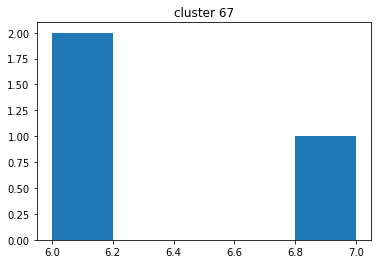

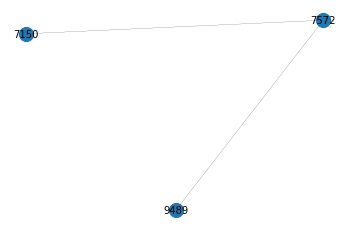

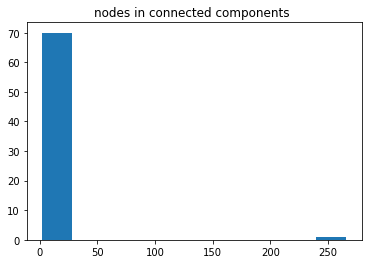

In [74]:
#find connected subgraphs
component_lengths = []
final_labels = np.zeros( codonmat.shape[1] )
for i,s in enumerate(S):
    component_lengths.append(len(s))
    if len(s) > 2:
        print(s.nodes())
        plt.figure()
        plt.title( 'cluster ' + str(i) )
        plt.hist( [ e[2]['weight'] for e in s.edges(data = True) ] , bins = 5)
        plt.show()
        pos = nx.spring_layout(s)  # positions for all nodes
        # nodes
        nx.draw_networkx_nodes(s, pos, node_size=200)
        # edges
        max_weight = np.amax([ e[2]['weight'] for e in s.edges(data = True) ] ) 
        edge_widths = 1 * np.log( np.array([ e[2]['weight'] for e in s.edges(data = True) ]) / max_weight )
        nx.draw_networkx_edges(s, pos, edgelist=s.edges(), width= edge_widths )
        # labels
        nx.draw_networkx_labels(s, pos, font_size=10, font_family="sans-serif")
        plt.axis("off")
        plt.show()
        final_labels[s.nodes()] = i
plt.figure()
plt.title( 'nodes in connected components ' )
plt.hist( component_lengths )
plt.show()



In [75]:
#write connected components as clusters
cluster_labelsb = final_labels
l,c = np.unique(cluster_labelsb, return_counts= True)
clusterdf = { label : [ codon_dict_rev[p] for p in list( np.where(cluster_labelsb == label )[0]  ) if p in codon_dict_rev ] for i,label in enumerate(list(l)) if c[i]> 1 } 
clusterdf = pd.DataFrame.from_dict( clusterdf , orient = 'index' , dtype=pd.Int64Dtype() )
print( clusterdf )
print(clusterdf.index)
clusterdf.to_csv( alnfile + 'jackknife_clusterpositions_columns.csv')

       0      1      2      3      4      5      6      7      8      9     \
0.0     805    814    817    820    823    826    829    832    835    838   
2.0    8536  21270  28618   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
3.0    1321  18816  24922  25458  28247  29557   <NA>   <NA>   <NA>   <NA>   
5.0     808   9748  11035  11107  14040  18939  25090  25488  29659   <NA>   
6.0     883    979   1102   1144   1147   1201   1228   1354   1366   1399   
7.0    1057   1093   8101  16380  18567  19152  24640  26064  26957  28097   
8.0    2446  20568  22198   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
9.0    2506  25503  25995   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
12.0   5104   8005  17658   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
13.0   6445   8164  10774  22402  22576  22579  23476  24976  25944  27297   
14.0   8641  15126  17109  18537  27402   <NA>   <NA>   <NA>   <NA>   <NA>   
16.0   9499  20274  29614   <NA>   <NA>   <NA>   <NA>   <NA>   <